# Notebook de Exemplos: Interpolação de Pontos na Reta Real

Este notebook demonstra o uso das seguintes funções de interpolação:

1.  `lin_interp`: Realiza a interpolação linear por partes entre os pontos.

2.  `poly_interp`: Calcula o polinômio interpolador (Interpolação Polinomial).

3.  `hermite_interp`: Calcula o polinômio interpolador de Hermite (usando valores e derivadas).

Todas as funções também demonstram a representação gráfica dos pontos e do polinômio/função interpoladora.

# Código - Hermite

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def hermite_interp(x_pontos: list, y_pontos: list, dy_pontos: list, allow_extrapolation: bool = False) -> object | None:
    """
    Cria uma função de interpolação polinomial de Hermite.
    
    Retorna:
        Uma função do tipo 'object' para fins de anotação ou None se der erro.

    Parâmetros:
        x_pontos: Coordenadas x (n valores).
        y_pontos: Coordenadas y (n valores).
        dy_pontos: Derivadas dy/dx em cada x (n valores).
        allow_extrapolation: Se False (padrão), levanta um ValueError 
                                 para valores de x fora do intervalo de dados.

    Raises:
        ValueError: Se `allow_extrapolation` for False e `x_novo`
                    estiver fora do intervalo [min(x_pontos), max(x_pontos)].
    Notas:
        Sobre a Extrapolação:
        Por padrão, esta biblioteca não permite extrapolação (allow_extrapolation=False).
        Isso evita que o polinômio seja avaliado em regiões onde ele
        tende a crescer rapidamente e perder precisão numérica.
    """
    try:
        x_pts = np.asarray(x_pontos, dtype=float)
        y_pts = np.asarray(y_pontos, dtype=float)
        dy_pts = np.asarray(dy_pontos, dtype=float)
    except Exception as e:
        print(f"Erro ao converter entradas para arrays numpy: {e}")
        return None

    n = len(x_pts)
    if n == 0:
        print("Erro: As listas de pontos não podem estar vazias.")
        return None
    if len(y_pts) != n or len(dy_pts) != n:
        print("Erro: As listas x, y, e dy devem ter o mesmo tamanho.")
        return None
        
    num_coefs = 2 * n
    
    x_min = np.min(x_pts)
    x_max = np.max(x_pts)
    
    A = np.zeros((num_coefs, num_coefs))
    b = np.zeros(num_coefs)
    
    for i in range(n):
        x = x_pts[i]
        
        A[2*i] = [x**j for j in range(num_coefs)]
        b[2*i] = y_pts[i]
        
        linha_dy = [0.0] + [j * x**(j-1) for j in range(1, num_coefs)]
        A[2*i + 1] = linha_dy
        b[2*i + 1] = dy_pts[i]
    
    try:
        coefs = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("Erro: Matriz singular. Verifique se há pontos x duplicados.")
        return None

    def polinomio_interpolador_hermite(x_novo: float | np.ndarray) -> float | np.ndarray:
        """
        Avalia o polinômio P(x_novo) = sum(c_j * x_novo^j)
        """
        x_val = np.asarray(x_novo, dtype=float)
        
        if not allow_extrapolation:
            out_of_bounds = (x_val < x_min) | (x_val > x_max)
            if np.any(out_of_bounds):
                raise ValueError(
                    f"Valores {x_val[out_of_bounds]} estão fora do intervalo de interpolação [{x_min}, {x_max}]. "
                    "Use allow_extrapolation=True para forçar o cálculo."
                )
                        
        return np.polyval(coefs[::-1], x_val)
    
    return polinomio_interpolador_hermite

def _ordenar_coordenadas_hermite(x: list, y: list, dy: list) -> tuple:
    """
    Ordena as coordenadas mantendo 'pareamento' para Hermite.

    Parâmetros:
    x: lista das coordenadas x, em x[i], de cada ponto i.
    y: lista das coordenadas y, em y[i], de cada ponto i.
    dy: lista das derivadas dy[i] em cada ponto i.

    Retorna:
    x_ord: lista das coordenadas x em ordem crescente.
    y_ord: lista das coordenadas y, pareadas com as coordenadas x.
    dy_ord: lista das derivadas, pareadas com as coordenadas x.
    """
    x_np = np.array(x)
    y_np = np.array(y)
    dy_np = np.array(dy)

    idx = np.argsort(x_np)

    x_ord = x_np[idx]
    y_ord = y_np[idx]
    dy_ord = dy_np[idx]

    return x_ord, y_ord, dy_ord

def _plotar_hermite(x: list, y: list, dy: list, f: Callable, titulo: str = "Interpolação de Hermite"):
    """
    Plotagem de pontos, derivadas e da função de interpolação.

    Parâmetros:
    x: lista das coordenadas x, em x[i], de cada ponto i.
    y: lista das coordenadas y, em y[i], de cada ponto i.
    dy: lista das derivadas dy[i] em cada ponto i.
    f: função de interpolação que será plotada.
    titulo: título do gráfico.

    Retorna:
    None
    """
    #criar pontos para a curva suave
    x_min, x_max = min(x), max(x)
    x_curve = np.linspace(x_min, x_max, 500)
    y_curve = f(x_curve)
    
    #calcular as retas tangentes nos pontos de interpolação
    comprimento_tangente = 0.1 * (x_max - x_min)  # 10% do intervalo
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    #gráfico principal
    ax.scatter(x, y, color='red', s=50, zorder=5, label='Pontos de dados')
    ax.plot(x_curve, y_curve, 'b-', linewidth=2, label='Polinômio de Hermite')
    
    #adc retas tangentes
    tangente_plotted = False
    for xi, yi, dyi in zip(x, y, dy):
        x_tang = [xi - comprimento_tangente, xi + comprimento_tangente]
        y_tang = [yi - comprimento_tangente * dyi, yi + comprimento_tangente * dyi]
        label = 'Tangente' if not tangente_plotted else ""
        ax.plot(x_tang, y_tang, 'g--', alpha=0.7, linewidth=1, label=label)
        if not tangente_plotted:
            tangente_plotted = True
        ax.plot(xi, yi, 'ro', markersize=8)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(titulo)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def hermite_interp_com_plot(x_pontos: list, y_pontos: list, dy_pontos: list, 
                           allow_extrapolation: bool = False, 
                           titulo: str = "Interpolação de Hermite") -> Callable:
    """
    Cria e plota uma função de interpolação polinomial de Hermite.

    Args:
        x_pontos: Coordenadas x (n valores).
        y_pontos: Coordenadas y (n valores).
        dy_pontos: Derivadas dy/dx em cada x (n valores).
        allow_extrapolation: Se permite extrapolação.
        titulo: Título para o gráfico.

    Returns:
        Função de interpolação de Hermite.
    """
    #ordenar coordenadas
    x_ord, y_ord, dy_ord = _ordenar_coordenadas_hermite(x_pontos, y_pontos, dy_pontos)
    
    #criar função de interpolação - p plotagem, permitimos extrapolação
    #p poder calcular derivadas numéricas nas bordas
    f_interp = hermite_interp(x_ord, y_ord, dy_ord, allow_extrapolation=True)
    
    if f_interp is None:
        print("Erro: Não foi possível criar a função de interpolação.")
        return None
    
    #plot
    _plotar_hermite(x_ord, y_ord, dy_ord, f_interp, titulo)

    #se o usuário não quiser extrapolação, cria outra versão restrita
    if not allow_extrapolation:
        def f_interp_restrita(x):
            x_val = np.asarray(x, dtype=float)
            x_min, x_max = min(x_ord), max(x_ord)
            
            if np.any((x_val < x_min) | (x_val > x_max)):
                raise ValueError(
                    f"Valores fora do intervalo [{x_min}, {x_max}]. "
                    "Use allow_extrapolation=True para forçar o cálculo."
                )
            return f_interp(x_val)
        
        return f_interp_restrita
    
    return f_interp

Exemplo 1


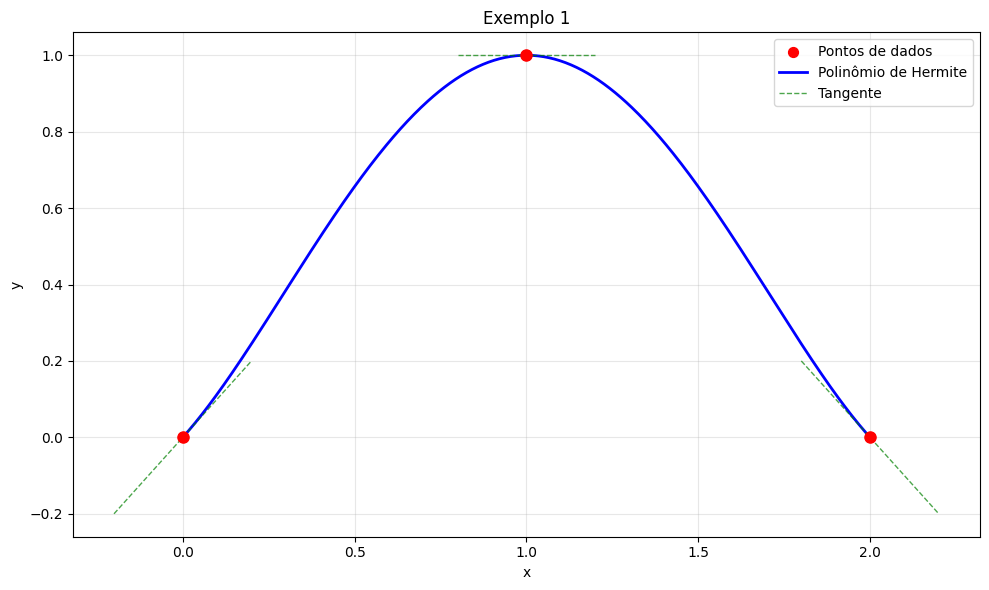

O valor interpolado em x=0.5 é: 0.6562
O valor interpolado em x=1.5 é: 0.6562


Exemplo 2: Pontos Não Ordenados e Derivadas Nulas


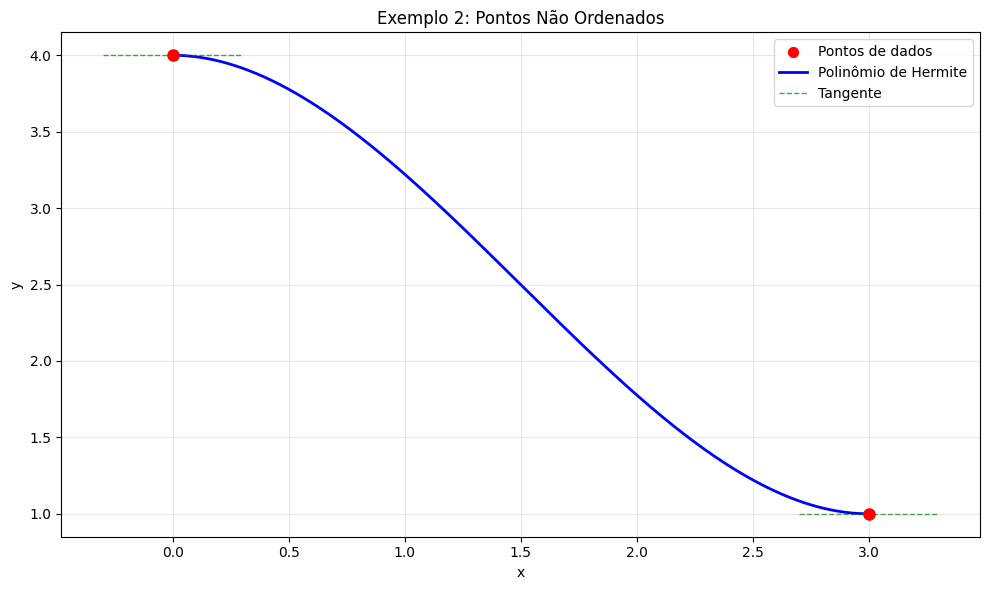

O valor interpolado em x=1.5 é: 2.5000


In [5]:
print("Exemplo 1")

x1 = [0, 1, 2]
y1 = [0, 1, 0]
dy1 = [1, 0, -1] 

p1 = hermite_interp_com_plot(x1, y1, dy1, titulo="Exemplo 1")

if p1:
    print(f"O valor interpolado em x=0.5 é: {p1(0.5):.4f}")
    print(f"O valor interpolado em x=1.5 é: {p1(1.5):.4f}")
    
print("\n")
print("Exemplo 2: Pontos Não Ordenados e Derivadas Nulas")

x2 = [3, 0]
y2 = [1, 4]
dy2 = [0, 0] 

p2 = hermite_interp_com_plot(x2, y2, dy2, titulo="Exemplo 2: Pontos Não Ordenados")

if p2:
    print(f"O valor interpolado em x=1.5 é: {p2(1.5):.4f}")

In [7]:
print("Teste da função 'hermite_interp'")

x_pts = [0, 1, 2]
y_pts = [0, 1, 0]
dy_pts = [1, 0, -1] 

f_calculada = hermite_interp(x_pts, y_pts, dy_pts, allow_extrapolation=False)

if f_calculada:

    print(f"f(0) = {f_calculada(0):.4f} (Esperado: 0.0)")
    print(f"f(1) = {f_calculada(1):.4f} (Esperado: 1.0)")
    print(f"f(2) = {f_calculada(2):.4f} (Esperado: 0.0)")
    print(f"f(0.5) = {f_calculada(0.5):.4f}")
    print(f"f(1.5) = {f_calculada(1.5):.4f}")
else:
    print("Falha ao criar a função.")

print("\nTeste de extrapolação (deve falhar)")
if f_calculada:
    try:
        valor = f_calculada(3.0)
        print(f"ERRO INESPERADO: f(3.0) = {valor}")
    except ValueError as e:
        print(f"SUCESSO: Erro de extrapolação capturado corretamente.")
        print(f"  -> Mensagem: {e}")

print("\n Teste de extrapolação (permitido)")
f_calculada_extrap = hermite_interp(x_pts, y_pts, dy_pts, allow_extrapolation=True)

if f_calculada_extrap:
    try:
        valor = f_calculada_extrap(3.0) 
        print(f"SUCESSO: Extrapolação permitida.")
        print(f"  -> f(3.0) = {valor:.4f}")
    except ValueError as e:
        print(f"ERRO INESPERADO: {e}")

Teste da função 'hermite_interp'
f(0) = 0.0000 (Esperado: 0.0)
f(1) = 1.0000 (Esperado: 1.0)
f(2) = 0.0000 (Esperado: 0.0)
f(0.5) = 0.6562
f(1.5) = 0.6562

Teste de extrapolação (deve falhar)
SUCESSO: Erro de extrapolação capturado corretamente.
  -> Mensagem: Valores [3.] estão fora do intervalo de interpolação [0.0, 2.0]. Use allow_extrapolation=True para forçar o cálculo.

 Teste de extrapolação (permitido)
SUCESSO: Extrapolação permitida.
  -> f(3.0) = 3.0000
